In [8]:
%load_ext autoreload
%autoreload 2

import parse_data.prepare_data as prepare_data
import parse_data.flip_rotate_trajectories as flip_rotate_trajectories
from analysis.response_times import calculate_response_times, plot_response_times
import data_extraction.get_indices as get_indices
import plotting.plot_octagon as plot_octagon
import globals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import analysis.loser_inferred_choice as loser_inferred_choice
import seaborn as sns
import data_strings


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
data_folder = data_strings.DATA_FOLDER
json_filenames_all_social = data_strings.JSON_FILENAMES_SOCIAL
json_filenames_all_solo = data_strings.JSON_FILENAMES_SOLO

In [18]:
json_filenames = json_filenames_all_social

In [19]:
# prepare the session dataframe and dataframes of each individual trial
df, trial_list = prepare_data.prepare_data(data_folder, json_filenames, combine=True)

filepath: C:\Users\tomha\OneDrive\PhD\SWC\data\first_experiments_2409\240913\2024-09-13_11-31-00_YansuJerrySocial.json
Data is from period before 2024-09-13 00:00:00
Running dataframe through playerinfo_playerposition_conversion.
Loading complete.
filepath: C:\Users\tomha\OneDrive\PhD\SWC\data\second_experiments_2409\240927\2024-09-27_14-25-20_SaraEmilySocial.json
Loading complete.
filepath: C:\Users\tomha\OneDrive\PhD\SWC\data\third_experiments_2410\241017\2024-10-17_14-28-40_ShamirAbigailSocial.json
Loading complete.
filepath: C:\Users\tomha\OneDrive\PhD\SWC\data\fourth_experiments_2410\241017\2024-10-17_16-41-38_ZimoElsaSocial.json
Loading complete.
filepath: C:\Users\tomha\OneDrive\PhD\SWC\data\fifth_experiments_241112\2024-11-12_13-31-14_KhadijaWendySocial.json
Loading complete.
filepath: C:\Users\tomha\OneDrive\PhD\SWC\data\sixth_experiments_241112\2024-11-12_15-23-24_FrancescaSenSzeSocial.json
Loading complete.
filepath: C:\Users\tomha\OneDrive\PhD\SWC\data\seventh_experiments_2

In [20]:
get_indices.get_trials_with_wall_sep(trial_list=trial_list, wall_sep=1).size

1082

In [21]:
## HEATMAPS ##

In [22]:
x_min = -20
x_max = 20
y_min = -20
y_max = 20

In [23]:
def heatmap_counts_from_location_data(location_array, n_rows=10, n_cols=10, x_min=x_min, x_max=x_max, 
                                      y_min=y_min, y_max=y_max):
    ''' Produce a matrix of counts across spatial location from n*2 location data '''

    # define a grid of counts
    grid_width = (x_max - x_min)/n_cols
    grid_height = (y_max - y_min)/n_rows
    grid = np.zeros([n_rows, n_cols])

    # Create a matrix of heatmap counts based on which bin starting location fits into
    for i in range(len(location_array[:,0])):
        x_val = location_array[i,0]
        y_val = location_array[i,1]
        x_bin = int((x_val - x_min)/grid_width)
        y_bin = int((y_val - y_min)/grid_height)

        if 0 <= y_bin < n_rows and 0 <= x_bin < n_cols:
            grid[y_bin, x_bin] += 1

    return grid

In [216]:
def plot_heatmap_from_count_array(ax, count_array, x_min=x_min, x_max=x_max, 
                                      y_min=y_min, y_max=y_max, vmin=None, vmax=None,
                                      difference_plot=False):

    # get the zipped coordinate list of octagon x and y vertex points
    octagon_vertex_coordinates = plot_octagon.return_octagon_path_points()

    # choose cmap based on whether this is a difference plot or single-condition plot
    cmap = 'plasma' if not difference_plot else 'PiYG'

    if vmin is None:
        # display heatmap, covering the full graph
        im = ax.imshow(count_array, extent=[x_min, x_max, y_min, y_max],
                   origin='lower', cmap=cmap)

    else:
        # display heatmap, covering the full graph
        im = ax.imshow(count_array, extent=[x_min, x_max, y_min, y_max],
                   origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)  
    
    # a matplotlib Artist with an edge and face colour
    patch = Polygon(octagon_vertex_coordinates, edgecolor='black', facecolor='none', lw=2)
    

    ax.add_patch(patch)         # make octagon outline visible
    im.set_clip_path(patch)     # crop image to coordinates inside the outline
    
    # Set aspect ratio to be square
    ax.set_aspect(1.)
    
    plt.colorbar(im)

    # ax.set_title("Count heatmap of winner location at the start of each trial")

    
    # # Loop over data dimensions and create text annotations.
    # coordinates = np.arange(x_min, x_max, count_array.shape[0])
    # for i in range(coordinates.size):
    #     for j in range(coordinates.size):
    #         text = ax.text(coordinates[j]+2.22, coordinates[i]+2.22, count_array[i, j],
    #                        ha="center", va="center", color="k")
    
    # give some white border to the graph
    ax.set_xlim([-22,22])
    ax.set_ylim([-22,22])


    print("total counts by location:\n", count_array)

    return ax

In [25]:
def plot_heatmap_from_count_array_sns(ax, count_array, bin_counts, x_min=x_min, x_max=x_max, 
                                      y_min=y_min, y_max=y_max, vmin=None, vmax=None):
    ''' Heatmap annotated with bin counts, no longer plotted over the octagon shape '''
    
    # probability data
    heatmap_data = count_array
    
    # count data
    annotation_data = bin_counts 

    # flip the y-axis
    heatmap_data = np.flipud(heatmap_data)
    annotation_data = np.flipud(bin_counts)
    
    # set up the x and y ranges for labeling bins from -20 to +20
    x_bins = np.linspace(-20, 20, 9)
    y_bins = np.linspace(-20, 20, 9)
    
    # create the heatmap
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(heatmap_data, annot=annotation_data, fmt=".0f", cmap="plasma", 
                     xticklabels=np.round(x_bins, 2), yticklabels=np.round(y_bins, 2),
                     vmin=0, vmax=1, # colourbar range
                     cbar_kws={'label': 'Heatmap Intensity'}, ax=ax)



    # get the zipped coordinate list of octagon x and y vertex points
    octagon_vertex_coordinates = plot_octagon.return_octagon_path_points()

    # a matplotlib Artist with an edge and face colour
    patch = Polygon(octagon_vertex_coordinates, edgecolor='black', facecolor='none', lw=2)
    

    ax.add_patch(patch)         # make octagon outline visible
    
    # Set labels
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_title("Heatmap with Separate Annotation Values")
    
    plt.show()

In [298]:
def winner_start_loc_heatmap(trial_list, wall_sep=1,
                             trial_type=None,
                             chosen_wall=None,
                             bin_counts=False,
                             nbins=10,
                             no_flip_rotate=False,
                             vmin=None,
                             vmax=None):
    ''' Plot a heatmap of the winner's location in the arena when the walls are
        revealed. This is done for all trials with a given wall separation, and 
        flipped and rotated to put WALL_1 at 0 degrees and WALL_2 at 45 
        degrees '''
    
    if wall_sep is not None:
        # filter trials for a wall separation of wall_sep
        trial_indices = get_indices.get_trials_with_wall_sep(trial_list, wall_sep=wall_sep) # verified correct indices
        print(f"number of trials with wall_sep {wall_sep} is: {trial_indices.size}")
    else:
        trial_indices = np.arange(len(trial_list))
    
    # further filter by HighLow trial type if specified
    if trial_type:
        trial_type_indices = get_indices.get_trials_trialtype(trial_list, trial_type=trial_type)
        trial_indices = np.intersect1d(trial_indices, trial_type_indices)
        print(f"number of trials with trial_type {trial_type} is: {trial_indices.size}")

    # further filter by chose High if specified
    if chosen_wall:
        chose_wall_trial_indices = get_indices.get_trials_chose_wall(trial_list, chosen_wall=chosen_wall)
        trial_indices = np.intersect1d(trial_indices, chose_wall_trial_indices)
        print(f"number of trials with chosen_wall {chosen_wall} is: {trial_indices.size}")
        
    trial_list_filtered = [trial_list[i] for i in trial_indices] # just list comp


    
    # flip and rotate the relevant trials for WALL_1 and WALL_2 to be walls 1 and 2
    flip_rotated_trials = []
    if no_flip_rotate:
        flip_rotated_trials = trial_list_filtered
        print("Not flipping or rotating")
    else:
        for trial in trial_list_filtered:
            flip_rotated_trials.append(flip_rotate_trajectories.flip_rotate_trajectories(trial=trial))  

            

    
    # get the ID of the player who ended the trial, for each trial
    trigger_activators_slice_onset_loc = get_indices.get_trigger_activators_slice_onset_loc(flip_rotated_trials)
    trigger_activators_slice_onset_loc = np.asarray(trigger_activators_slice_onset_loc)
    
    # generate heat map data and plot
    count_array = heatmap_counts_from_location_data(trigger_activators_slice_onset_loc, n_cols=nbins, n_rows=nbins)
    print(f"number of trials in count_array is: {np.sum(count_array)}")
    ax = plot_octagon.plot_octagon()
    plot_heatmap_from_count_array(ax, count_array, vmin=vmin, vmax=vmax)

    if not bin_counts:
        return ax
    else:
        return ax, count_array

In [297]:
def loser_start_loc_heatmap(trial_list, wall_sep=1,
                             trial_type=None,
                             chosen_wall=None,
                             bin_counts = False,
                             nbins=10,
                             no_flip_rotate = False,
                             vmin=None,
                             vmax=None):
    ''' Plot a heatmap of the loser's location in the arena when the walls are
        revealed. This is done for all trials with a given wall separation, and 
        flipped and rotated to put WALL_1 at 0 degrees and WALL_2 at 45 
        degrees '''
    
    if wall_sep is not None:
        # filter trials for a wall separation of wall_sep
        trial_indices = get_indices.get_trials_with_wall_sep(trial_list, wall_sep=wall_sep) # verified correct indices
    else:
        trial_indices = np.arange(len(trial_list))
    
    # further filter by HighLow trial type if specified
    if trial_type:
        trial_type_indices = get_indices.get_trials_trialtype(trial_list, trial_type=trial_type)
        trial_indices = np.intersect1d(trial_indices, trial_type_indices)

    # further filter by chose High if specified
    if chosen_wall:
        chose_wall_trial_indices = get_indices.get_trials_chose_wall(trial_list, chosen_wall=chosen_wall)
        trial_indices = np.intersect1d(trial_indices, chose_wall_trial_indices)
        
    trial_list_filtered = [trial_list[i] for i in trial_indices] # just list comp
    
    # flip and rotate the relevant trials for WALL_1 and WALL_2 to be walls 1 and 2
    flip_rotated_trials = []
    if no_flip_rotate:
        flip_rotated_trials = trial_list_filtered
        print("Not flipping or rotating")
    else:
        for trial in trial_list_filtered:
            flip_rotated_trials.append(flip_rotate_trajectories.flip_rotate_trajectories(trial=trial))  


    
    # get the ID of the player who ended the trial, for each trial
    trigger_activators = get_indices.get_trigger_activators(trial_list)
    loser_ids = 1 - trigger_activators # if the winner was 1, loser_id is 0, and vice versa
    losers_slice_onset_loc = get_indices.get_player_slice_onset_locs(flip_rotated_trials, player_id_list=loser_ids)
    losers_slice_onset_loc = np.asarray(losers_slice_onset_loc)
    
    # generate heat map data and plot
    count_array = heatmap_counts_from_location_data(losers_slice_onset_loc, n_cols=nbins, n_rows=nbins)
    ax = plot_octagon.plot_octagon()
    plot_heatmap_from_count_array(ax, count_array, vmin=vmin, vmax=vmax)

    if not bin_counts:
        return ax
    else:
        return ax, count_array

In [50]:
def start_loc_heatmap(trial_list, wall_sep=1,
                             trial_type=None,
                             chosen_wall=None,
                             bin_counts=False):
    ''' Plot a heatmap of both players location in the arena when the walls are
    revealed. This is done for all trials with a given wall separation, and 
    flipped and rotated to put WALL_1 at 0 degrees and WALL_2 at 45 
    degrees '''
    
    if wall_sep is not None:
        # filter trials for a wall separation of wall_sep
        trial_indices = get_indices.get_trials_with_wall_sep(trial_list, wall_sep=wall_sep) # verified correct indices
    else:
        trial_indices = np.arange(len(trial_list))
    
    # further filter by HighLow trial type if specified
    if trial_type:
        trial_type_indices = get_indices.get_trials_trialtype(trial_list, trial_type=trial_type)
        trial_indices = np.intersect1d(trial_indices, trial_type_indices)
    
    # further filter by chose High if specified
    if chosen_wall:
        chose_wall_trial_indices = get_indices.get_trials_chose_wall(trial_list, chosen_wall=chosen_wall)
        trial_indices = np.intersect1d(trial_indices, chose_wall_trial_indices)
        
    trial_list_filtered = [trial_list[i] for i in trial_indices] # just list comp
    
    # flip and rotate the relevant trials for WALL_1 and WALL_2 to be walls 1 and 2
    flip_rotated_trials = []
    for trial in trial_list_filtered:
        flip_rotated_trials.append(flip_rotate_trajectories.flip_rotate_trajectories(trial=trial)) 
    
    # get the positions of both players for each trial, and include both
    print(f" flip_rotate_trials len: {len(flip_rotated_trials)}")
    player_0_slice_onset_loc = get_indices.get_player_slice_onset_locs(flip_rotated_trials, player_id_list=np.zeros(len(flip_rotated_trials)))
    player_0_slice_onset_loc = np.asarray(player_0_slice_onset_loc)
    print(f"player_0_slice_onset_loc shape = {player_0_slice_onset_loc.shape}")
    
    player_1_slice_onset_loc = get_indices.get_player_slice_onset_locs(flip_rotated_trials, player_id_list=np.ones(len(flip_rotated_trials)))
    player_1_slice_onset_loc = np.asarray(player_1_slice_onset_loc)

    slice_onset_locs = np.vstack([player_0_slice_onset_loc, player_1_slice_onset_loc])
    # generate heat map data and plot
    count_array = heatmap_counts_from_location_data(slice_onset_locs)
    ax = plot_octagon.plot_octagon()
    plot_heatmap_from_count_array(ax, count_array)
    
    if not bin_counts:
        return ax
    else:
        return ax, count_array

In [29]:
def probability_chose_wall_location_heatmap(trial_list, wall_sep=1,
                                            trial_type=None,
                                            chosen_wall=globals.WALL_1,
                                            include_inferred_choice=True,
                                            bincounts=False):
    ''' Plot a heatmap of the probability of choosing a specific wall against the chooser's slice onset location
        This can be restricted by: trial type, wall separation'''

    ## FILTERING -----------------
    
    # filter trials for a wall separation of wall_sep
    trial_indices = get_indices.get_trials_with_wall_sep(trial_list, wall_sep=wall_sep) # verified correct indices
    
    # further filter by trial type if specified
    if trial_type:
        trial_type_indices = get_indices.get_trials_trialtype(trial_list, trial_type=trial_type)
        trial_indices = np.intersect1d(trial_indices, trial_type_indices)
    
    # further filter by chosen wall
    chose_wall_trial_indices = get_indices.get_trials_chose_wall(trial_list, chosen_wall=chosen_wall)
    chose_wall_trial_indices = np.intersect1d(trial_indices, chose_wall_trial_indices)

    ## -----------------------
    
    # filter the trials lists by these indices
    trial_list_filtered = [trial_list[i] for i in trial_indices] # just list comp
    trial_list_filtered_chose_wall = [trial_list[i] for i in chose_wall_trial_indices] 

    ## FIND FLIPPED LOCATIONS -----------------------
    
    # flip and rotate the relevant trials for WALL_1 and WALL_2 to be walls 1 and 2
    flip_rotated_trials = []
    for trial in trial_list_filtered:
        flip_rotated_trials.append(flip_rotate_trajectories.flip_rotate_trajectories(trial=trial)) 
    flip_rotated_trials_chose_wall = []
    for trial in trial_list_filtered_chose_wall:
        flip_rotated_trials_chose_wall.append(flip_rotate_trajectories.flip_rotate_trajectories(trial=trial)) 
    
    # get the ID of the player who ended the trial, for each trial
    # then get this player's location. This makes up the actual-choice data
    trigger_activators_slice_onset_loc = get_indices.get_trigger_activators_slice_onset_loc(flip_rotated_trials)
    trigger_activators_slice_onset_loc = np.asarray(trigger_activators_slice_onset_loc)
    trigger_activators_slice_onset_loc_chose_wall = get_indices.get_trigger_activators_slice_onset_loc(flip_rotated_trials_chose_wall)
    trigger_activators_slice_onset_loc_chose_wall = np.asarray(trigger_activators_slice_onset_loc_chose_wall)

    ## -----------------------

    ## INFERRED CHOICE ----------------------------
    
    # if we are including inferred choice we want another two trial lists: relevant trials where inferred choice was confident, 
    # and relevant trials where inferred choice was confident and the choice was relevant
    # These will be the 2 arrays we use to find the probability for each location
    if include_inferred_choice:
        # identify inferred choice for all trials in session
        (loser_inferred_choice_wall_num,
        loser_inferred_choice_confidence) = loser_inferred_choice.infer_loser_choice_session(trial_list) # get inferred choices

        ## FILTERING -------------------
        
        # loop through each relevant trial index and identify if the loser's choice was confident
        trial_indices_inferred_choice_confident = []
        for trial_idx in trial_indices:
            if loser_inferred_choice_confidence[trial_idx] == True:
                trial_indices_inferred_choice_confident.append(trial_idx)

        print(f"trial_indices_inferred_choice_confident: {len(trial_indices_inferred_choice_confident)}")
        
        # loop through each relevant trial index and identify if the loser's choice was confident and the relevant wall
        trial_indices_inferred_choice_confident_and_relevant = []
        for trial_idx in trial_indices:
            # get the relevant wall number
            this_trial = trial_list[trial_idx]
            this_trial_walls = get_indices.get_walls(this_trial)
            relevant_wall_num = this_trial_walls[0] if chosen_wall == globals.WALL_1 else this_trial_walls[1]
            
            if loser_inferred_choice_confidence[trial_idx] == True and loser_inferred_choice_wall_num[trial_idx] == relevant_wall_num:
                trial_indices_inferred_choice_confident_and_relevant.append(trial_idx)

        print(f"trial_indices_inferred_choice_confident_and_relevant: {len(trial_indices_inferred_choice_confident_and_relevant)}")

        
        ## -------------------------------

        # filter the trials lists by these indices
        trial_list_filtered_inferred_choice_confident = [trial_list[i] for i in trial_indices_inferred_choice_confident] # just list comp
        trial_list_filtered_chose_wall_inferred_choice_confident = [trial_list[i] for i in trial_indices_inferred_choice_confident_and_relevant] 

        print(f"len trial_list_filtered_inferred_choice_confident = {len(trial_list_filtered_inferred_choice_confident)}")
        print(f"len trial_list_filtered_chose_wall_inferred_choice_confident = {len(trial_list_filtered_chose_wall_inferred_choice_confident)}")


        ## FIND FLIPPED LOCATIONS -----------------------

        # flip and rotate the relevant trials for WALL_1 and WALL_2 to be walls 1 and 2
        flip_rotated_trials_inferred_choice_confident = []
        for trial in trial_list_filtered_inferred_choice_confident:
            flip_rotated_trials_inferred_choice_confident.append(flip_rotate_trajectories.flip_rotate_trajectories(trial)) 
        flip_rotated_trials_chose_wall_inferred_choice_confident = []
        for trial in trial_list_filtered_chose_wall_inferred_choice_confident:
            flip_rotated_trials_chose_wall_inferred_choice_confident.append(flip_rotate_trajectories.flip_rotate_trajectories(trial)) 
        print(f"len flip_rotated_trials_inferred_choice_confident = {len(flip_rotated_trials_inferred_choice_confident)}")
        print(f"len flip_rotated_trials_chose_wall_inferred_choice_confident = {len(flip_rotated_trials_chose_wall_inferred_choice_confident)}")


        
        
        loser_slice_onset_loc = np.zeros([2,len(trial_list_filtered_inferred_choice_confident)])
        for i in range(len(trial_list_filtered_inferred_choice_confident)):
            
            this_trial = flip_rotated_trials_inferred_choice_confident[i]
            
            # identify loser id
            winner_id = get_indices.get_trigger_activator(this_trial)
            loser_id = 1 if winner_id == 0 else 0

            # loser location
            (loser_x_loc_slice_onset, 
             loser_y_loc_slice_onset) = get_indices.get_player_slice_onset_loc(this_trial, loser_id)

            loser_slice_onset_loc[:,i] = [loser_x_loc_slice_onset, loser_y_loc_slice_onset]
        
        loser_slice_onset_loc_chose_wall = np.zeros([2,len(trial_list_filtered_chose_wall_inferred_choice_confident)])
        for i in range(len(trial_list_filtered_chose_wall_inferred_choice_confident)):
            
            this_trial = flip_rotated_trials_chose_wall_inferred_choice_confident[i]
            
            # identify loser id
            winner_id = get_indices.get_trigger_activator(this_trial)
            loser_id = 1 if winner_id == 0 else 0

            # loser location
            (loser_x_loc_slice_onset, 
             loser_y_loc_slice_onset) = get_indices.get_player_slice_onset_loc(this_trial, loser_id)

            loser_slice_onset_loc_chose_wall[:,i] = [loser_x_loc_slice_onset, loser_y_loc_slice_onset]

        print(f" shape[1] of loser_slice_onset_loc = {loser_slice_onset_loc.shape[1]}")  
        print(f" shape[1] of loser_slice_onset_loc_chose_wall = {loser_slice_onset_loc_chose_wall.shape[1]}")

        print(f" loser_slice_onset_loc: {loser_slice_onset_loc[:,30:40]}")
        print(f" loser_slice_onset_loc: {loser_slice_onset_loc_chose_wall[:,30:40]}") 

        ## --------------------------

        ## COUNT ARRAYS --------------------------
        count_array_inferred_choice_confident = heatmap_counts_from_location_data(loser_slice_onset_loc.T, n_rows=9, n_cols=9)
        count_array_inferred_choice_confident_chose_wall = heatmap_counts_from_location_data(loser_slice_onset_loc_chose_wall.T, n_rows=9, n_cols=9)


        print("total inferred_choice trial counts by location:\n", count_array_inferred_choice_confident)
        print("chose inferred_choice relevant_wall counts by location:\n", count_array_inferred_choice_confident_chose_wall)

        ## -----------------------

    ## -------------------- END INFERRED CHOICE

           
            

    
    # get counts by location for all trials and for winner-chose-wall trials
    count_array = heatmap_counts_from_location_data(trigger_activators_slice_onset_loc, n_rows=9, n_cols=9)
    count_array_chose_wall = heatmap_counts_from_location_data(trigger_activators_slice_onset_loc_chose_wall, n_rows=9, n_cols=9)

    print("total trial counts by location:\n", count_array)
    print("chose wall counts by location:\n", count_array_chose_wall)

    ## IF INFERRED CHOICE, ADD THE INFERRED CHOICE COUNT ARRAYS TO THE STANDARD ONES
    if include_inferred_choice:
        count_array = count_array + count_array_inferred_choice_confident
        count_array_chose_wall = count_array_chose_wall + count_array_inferred_choice_confident_chose_wall

    # element-wise division, avoiding division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        probability_count_array = np.divide(count_array_chose_wall, count_array)
        probability_count_array[count_array == 0] = np.nan  # Set divisions by zero to NaN

    # remove bins with too few trials
    probability_count_array[count_array < 4] = np.nan  
    
    ax = plot_octagon.plot_octagon()
    if bincounts:
        plot_heatmap_from_count_array_sns(ax, probability_count_array, count_array, vmin=0, vmax=1)
    else:
        plot_heatmap_from_count_array(ax, probability_count_array, vmin=0, vmax=1)

    return ax

 flip_rotate_trials len: 1949
player_0_slice_onset_loc shape = (1949, 2)
total counts by location:
 [[  0.   0.   0.   3.  18.   8.   2.   0.   0.   0.]
 [  0.   5.   8.   8.  13.  19.  13.  12.  10.   0.]
 [  0.  12.  17.  23.  31.  47.  24.  13.  18.   0.]
 [  8.  11.  23.  76. 111. 129.  41.  18.  11.   4.]
 [  9.  13.  35. 125. 422. 436. 112.  35.  11.   8.]
 [ 13.  14.  35. 127. 419. 428. 129.  29.   7.  12.]
 [  3.  14.  24.  64. 110. 123.  67.  19.  18.   2.]
 [  0.   7.  13.  24.  31.  53.  22.  15.  11.   0.]
 [  0.   8.  14.   7.  14.  16.  11.  11.  10.   0.]
 [  0.   0.   0.   5.  11.  16.   0.   0.   0.   0.]]


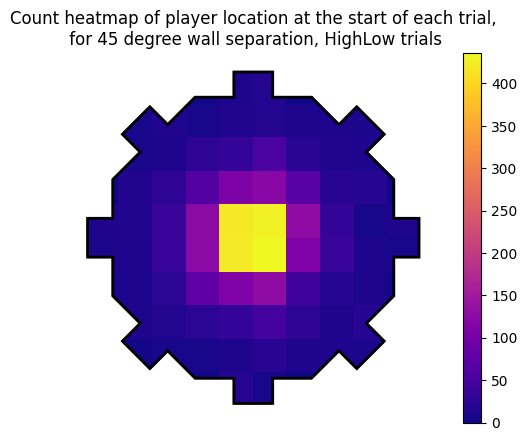

In [45]:
ax = start_loc_heatmap(trial_list, wall_sep=None,
                             trial_type=globals.HIGH_LOW,
                             chosen_wall=None)
ax.set_title("Count heatmap of player location at the start of each trial,\n for 45 degree wall separation, HighLow trials")
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.gca().tick_params(left=False, bottom=False)  # Turn off major ticks
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.show()

number of trials with trial_type HighLow is: 1949
number of trials in count_array is: 1949.0
total counts by location:
 [[  0.   0.   0.   1.   5.   3.   0.   0.   0.   0.]
 [  0.   2.   3.   2.   4.   5.   3.   6.   6.   0.]
 [  0.   2.   1.   4.  11.  18.   9.   3.   5.   0.]
 [  3.   2.   8.  23.  40.  59.  16.   9.   3.   1.]
 [  5.   5.  11.  66. 197. 223.  54.  17.   4.   7.]
 [  9.   8.  18.  58. 212. 244.  82.  13.   3.  10.]
 [  0.   6.   9.  31.  59.  79.  45.  11.  11.   2.]
 [  0.   5.   5.  14.  19.  30.  19.  12.   6.   0.]
 [  0.   8.   7.   4.   7.  11.   7.   8.   9.   0.]
 [  0.   0.   0.   1.   6.  15.   0.   0.   0.   0.]]


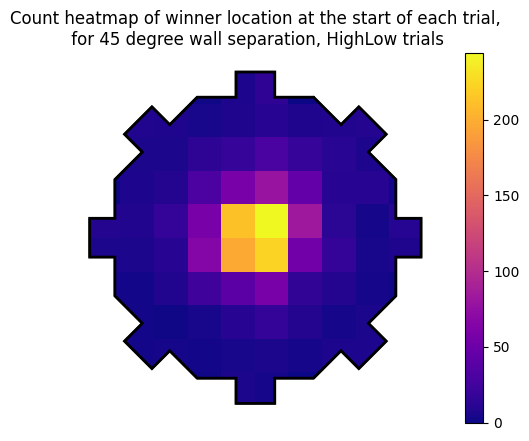

In [46]:
ax = winner_start_loc_heatmap(trial_list, wall_sep=None,
                             trial_type=globals.HIGH_LOW,
                             chosen_wall=None)
ax.set_title("Count heatmap of winner location at the start of each trial,\n for 45 degree wall separation, HighLow trials")
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.gca().tick_params(left=False, bottom=False)  # Turn off major ticks
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.show()

total counts by location:
 [[  0.   0.   0.   3.  11.   3.   0.   0.   0.   0.]
 [  0.   4.   3.   4.   5.  11.   8.   4.   7.   0.]
 [  0.   5.   8.  10.  19.  27.  10.   8.   7.   0.]
 [  2.   9.   6.  40.  54.  64.  18.   8.   6.   2.]
 [  5.   5.  15.  59. 207. 217.  58.  14.   6.   4.]
 [  5.   6.  20.  62. 212. 211.  65.  20.   4.   7.]
 [  2.   9.  14.  35.  56.  59.  33.  12.   8.   2.]
 [  0.   3.   6.  13.  15.  26.  10.   6.   7.   0.]
 [  0.   3.   7.   2.   8.   8.   6.   5.   5.   0.]
 [  0.   0.   0.   4.   6.  11.   0.   0.   0.   0.]]


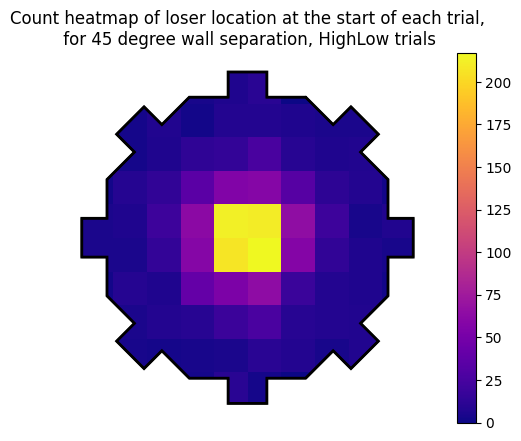

In [47]:
ax = loser_start_loc_heatmap(trial_list, wall_sep=None,
                             trial_type=globals.HIGH_LOW,
                             chosen_wall=None)
ax.set_title("Count heatmap of loser location at the start of each trial,\n for 45 degree wall separation, HighLow trials")
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.gca().tick_params(left=False, bottom=False)  # Turn off major ticks
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.show()

number of trials with wall_sep 2 is: 793
number of trials with trial_type HighLow is: 631
number of trials in count_array is: 631.0
total counts by location:
 [[ 0.  0.  0.  1.  7.  3.  1.  0.  0.  0.]
 [ 0.  4.  0.  2.  0.  1.  0.  3.  2.  0.]
 [ 0.  3.  4.  2.  5.  5.  2.  2.  4.  0.]
 [ 1.  2.  5. 12. 19. 19.  4.  2.  3.  0.]
 [ 4.  2.  5. 18. 67. 71. 25. 10.  4.  3.]
 [ 7.  4.  2. 10. 50. 61. 11.  2.  3.  4.]
 [ 3.  3.  5. 17. 19. 23.  8.  2.  1.  2.]
 [ 0.  3.  2.  2.  9.  3.  3.  3.  2.  0.]
 [ 0.  5.  3.  1.  1.  3.  2.  2.  8.  0.]
 [ 0.  0.  0.  1.  5.  5.  4.  0.  0.  0.]]


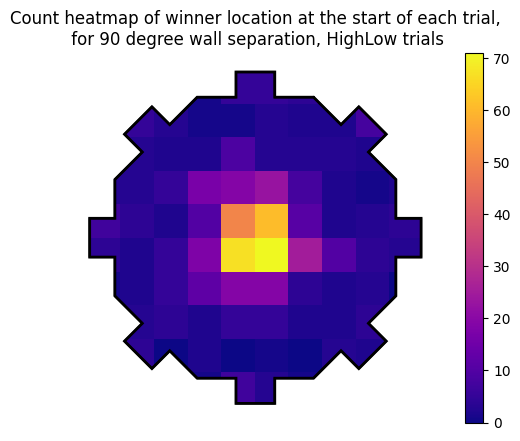

In [19]:
ax = winner_start_loc_heatmap(trial_list, wall_sep=2,
                             trial_type=globals.HIGH_LOW,
                             chosen_wall=None)
ax.set_title("Count heatmap of winner location at the start of each trial,\n for 90 degree wall separation, HighLow trials")
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.gca().tick_params(left=False, bottom=False)  # Turn off major ticks
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.show()

number of trials with wall_sep 4 is: 623
number of trials with trial_type HighLow is: 496
number of trials in count_array is: 496.0
total counts by location:
 [[ 0.  0.  0.  1.  1.  2.  0.  0.  0.  0.]
 [ 0.  1.  3.  0.  2.  3.  3.  3.  1.  0.]
 [ 0.  0.  1.  2.  5.  7.  3.  2.  2.  0.]
 [ 1.  1.  0. 11.  7. 21.  7.  4.  1.  0.]
 [ 0.  0.  5. 19. 52. 65.  6.  2.  1.  2.]
 [ 6.  1.  4. 14. 58. 58. 22.  3.  2.  0.]
 [ 0.  1.  1.  9. 11. 15.  7.  2.  2.  0.]
 [ 0.  1.  2.  0.  4.  6.  3.  2.  0.  0.]
 [ 0.  4.  0.  1.  2.  4.  0.  0.  2.  0.]
 [ 0.  0.  0.  0.  0.  2.  0.  0.  0.  0.]]


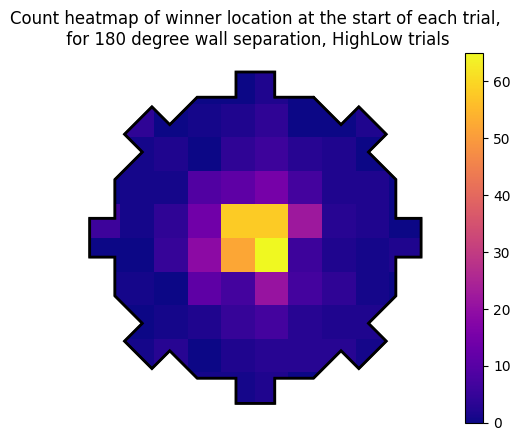

In [37]:
ax = winner_start_loc_heatmap(trial_list, wall_sep=4,
                             trial_type=globals.HIGH_LOW,
                             chosen_wall=None)
ax.set_title("Count heatmap of winner location at the start of each trial,\n for 180 degree wall separation, HighLow trials")
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.gca().tick_params(left=False, bottom=False)  # Turn off major ticks
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.show()

number of trials with wall_sep 1 is: 1082
number of trials with trial_type HighLow is: 880
number of trials with chosen_wall data.wall1 is: 728
number of trials in count_array is: 728.0
total counts by location:
 [[ 0.  0.  0.  0.  1.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  1.  0.  0.  1.  0.  0.]
 [ 0.  1.  0.  1.  4.  7.  3.  0.  1.  0.]
 [ 2.  1.  6.  7. 20. 21.  4.  1.  1.  1.]
 [ 2.  3.  1. 30. 76. 84. 21.  4.  2.  3.]
 [ 2.  3.  8. 23. 80. 98. 23.  2.  0.  2.]
 [ 0.  5.  5. 17. 23. 25. 19.  4.  0.  1.]
 [ 0.  3.  0. 11.  7. 12.  3.  5.  2.  0.]
 [ 0.  2.  4.  1.  3.  1.  3.  5.  0.  0.]
 [ 0.  0.  0.  1.  4.  9.  0.  0.  0.  0.]]


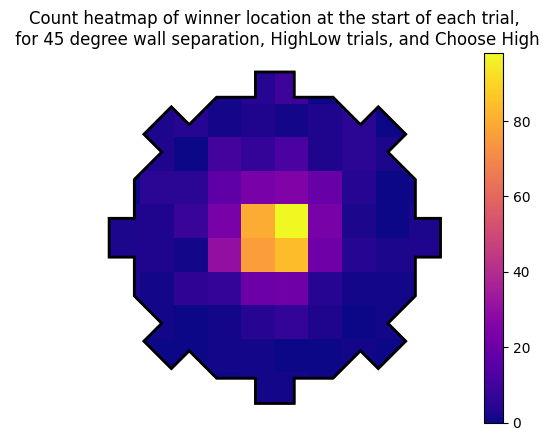

In [39]:
ax = winner_start_loc_heatmap(trial_list, wall_sep=1,
                             trial_type=globals.HIGH_LOW,
                             chosen_wall=globals.WALL_1)
ax.set_title("Count heatmap of winner location at the start of each trial,\n for 45 degree wall separation, HighLow trials, and Choose High")
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.gca().tick_params(left=False, bottom=False)  # Turn off major ticks
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.show()

number of trials with wall_sep 1 is: 1082
number of trials with trial_type HighLow is: 880
number of trials with chosen_wall data.wall2 is: 152
number of trials in count_array is: 152.0
total counts by location:
 [[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  3.  0.]
 [ 0.  0.  0.  0.  0.  2.  1.  1.  2.  0.]
 [ 0.  0.  1.  1.  4.  3.  1.  2.  1.  0.]
 [ 0.  1.  0.  1.  8. 11. 10.  5.  0.  0.]
 [ 0.  0.  0.  4.  6. 21.  8.  1.  1.  4.]
 [ 0.  0.  1.  0.  3.  9.  7.  3.  1.  0.]
 [ 0.  0.  0.  0.  0.  3.  6.  2.  2.  0.]
 [ 0.  0.  0.  0.  1.  2.  2.  2.  3.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]]


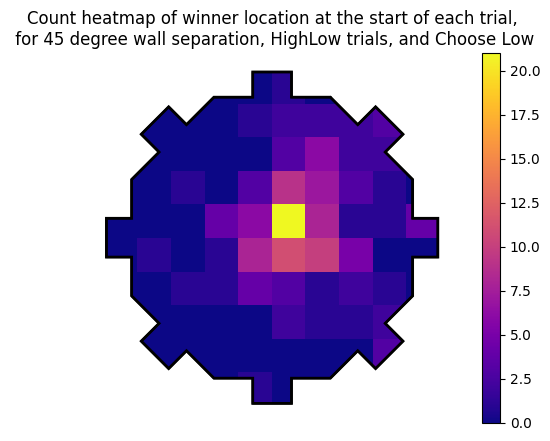

In [40]:
ax = winner_start_loc_heatmap(trial_list, wall_sep=1,
                             trial_type=globals.HIGH_LOW,
                             chosen_wall=globals.WALL_2)
ax.set_title("Count heatmap of winner location at the start of each trial,\n for 45 degree wall separation, HighLow trials, and Choose Low")
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.gca().tick_params(left=False, bottom=False)  # Turn off major ticks
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.show()

number of trials with wall_sep 2 is: 720
number of trials with trial_type HighLow is: 573
number of trials with chosen_wall data.wall1 is: 390
number of trials in count_array is: 390.0
total counts by location:
 [[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  1.  1.  0.  1.  0.  0.]
 [ 0.  1.  0.  1.  1.  0.  1.  0.  0.  0.]
 [ 0.  0.  1.  1.  9.  8.  2.  1.  0.  0.]
 [ 3.  1.  5. 13. 42. 51. 11.  1.  0.  0.]
 [ 1.  4.  4. 15. 53. 37. 15.  5.  0.  0.]
 [ 0.  0.  1.  4. 15. 23.  5.  0.  6.  0.]
 [ 0.  1.  3.  3.  7.  5.  4.  1.  0.  0.]
 [ 0.  2.  3.  2.  1.  2.  1.  1.  4.  0.]
 [ 0.  0.  0.  0.  2.  2.  0.  0.  0.  0.]]


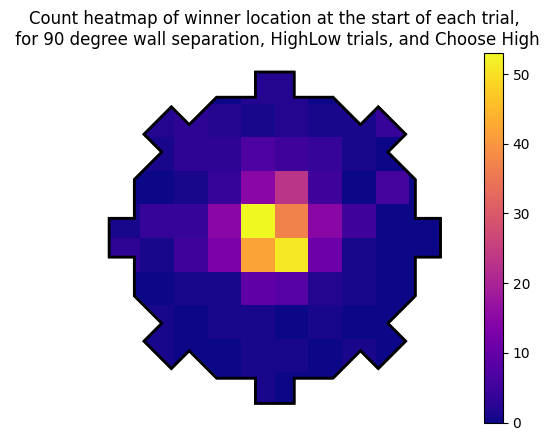

In [41]:
ax = winner_start_loc_heatmap(trial_list, wall_sep=2,
                             trial_type=globals.HIGH_LOW,
                             chosen_wall=globals.WALL_1)
ax.set_title("Count heatmap of winner location at the start of each trial,\n for 90 degree wall separation, HighLow trials, and Choose High")
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.gca().tick_params(left=False, bottom=False)  # Turn off major ticks
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.show()

number of trials with wall_sep 4 is: 623
number of trials with trial_type HighLow is: 496
number of trials with chosen_wall data.wall1 is: 287
number of trials in count_array is: 287.0
total counts by location:
 [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  2.  1.  1.  1.  0.  0.]
 [ 1.  1.  0.  6.  0.  5.  3.  0.  0.  0.]
 [ 0.  0.  3. 13. 35. 40.  1.  0.  1.  0.]
 [ 6.  1.  4.  6. 39. 30. 13.  2.  2.  0.]
 [ 0.  1.  1.  6.  8. 11.  5.  2.  2.  0.]
 [ 0.  1.  2.  0.  3.  6.  3.  2.  0.  0.]
 [ 0.  4.  0.  1.  2.  4.  0.  0.  2.  0.]
 [ 0.  0.  0.  0.  0.  2.  0.  0.  0.  0.]]


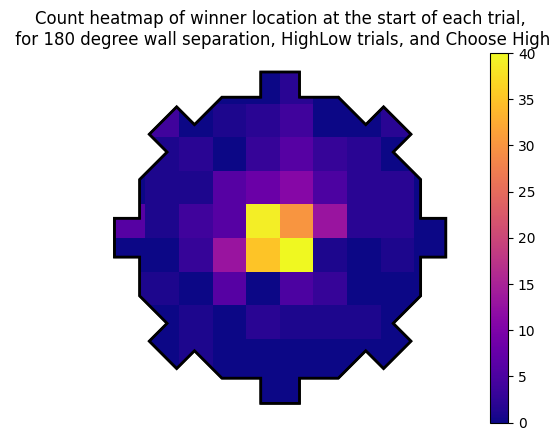

In [42]:
ax = winner_start_loc_heatmap(trial_list, wall_sep=4,
                             trial_type=globals.HIGH_LOW,
                             chosen_wall=globals.WALL_1)
ax.set_title("Count heatmap of winner location at the start of each trial,\n for 180 degree wall separation, HighLow trials, and Choose High")
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.gca().tick_params(left=False, bottom=False)  # Turn off major ticks
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.show()

total counts by location:
 [[  0.   0.   0.   0.   4.   2.   1.   0.   0.   0.]
 [  0.   1.   0.   1.   2.   4.   4.   2.   4.   0.]
 [  0.   2.   1.   4.   8.  13.   6.   5.   5.   0.]
 [  1.   1.   7.  16.  30.  26.   8.   5.   5.   1.]
 [  1.   5.   9.  30.  82. 100.  31.   7.   3.   2.]
 [  2.   4.   9.  31.  87. 100.  31.   3.   0.   2.]
 [  3.   5.   9.  13.  18.  29.  19.   7.   4.   1.]
 [  0.   1.   2.   7.   5.   9.   2.   7.   1.   0.]
 [  0.   1.   4.   2.   4.   0.   4.   3.   2.   0.]
 [  0.   0.   0.   2.   6.   2.   0.   0.   0.   0.]]


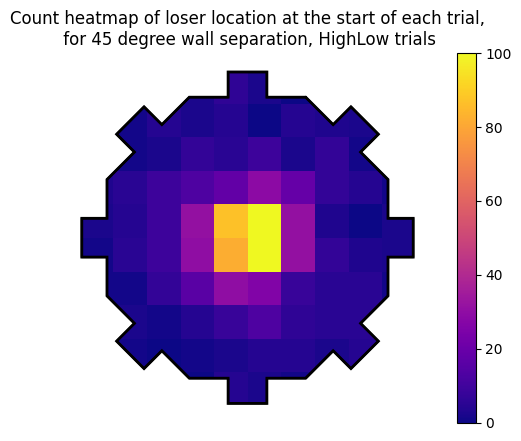

In [43]:
ax = loser_start_loc_heatmap(trial_list, wall_sep=1,
                             trial_type=globals.HIGH_LOW)
ax.set_title("Count heatmap of loser location at the start of each trial,\n for 45 degree wall separation, HighLow trials")
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.gca().tick_params(left=False, bottom=False)  # Turn off major ticks
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.show()

total counts by location:
 [[ 0.  0.  0.  0.  2.  0.  1.  0.  0.  0.]
 [ 0.  3.  1.  0.  3.  1.  1.  3.  0.  0.]
 [ 0.  4.  4.  4.  5.  3.  5.  0.  1.  0.]
 [ 1.  1.  5. 12. 19. 21.  8.  4.  1.  0.]
 [ 3.  2.  3. 16. 67. 57. 14.  9.  2.  1.]
 [ 1.  1.  5. 17. 58. 67. 21.  7.  0.  1.]
 [ 0.  1.  6.  7. 16. 20.  8.  1.  4.  0.]
 [ 0.  1.  3.  4.  4.  6.  2.  1.  0.  0.]
 [ 0.  1.  1.  2.  3.  3.  2.  1.  5.  0.]
 [ 0.  0.  0.  2.  2.  2.  0.  0.  0.  0.]]


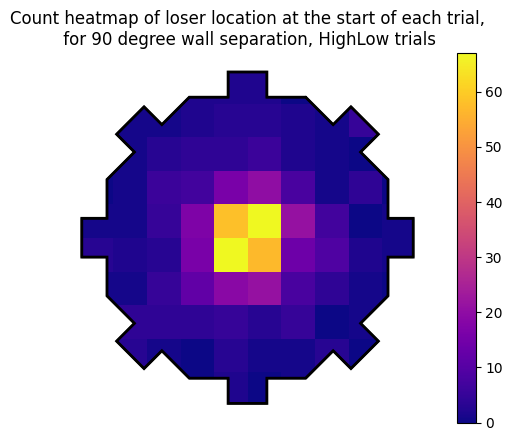

In [44]:
ax = loser_start_loc_heatmap(trial_list, wall_sep=2,
                             trial_type=globals.HIGH_LOW)
ax.set_title("Count heatmap of loser location at the start of each trial,\n for 90 degree wall separation, HighLow trials")
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.gca().tick_params(left=False, bottom=False)  # Turn off major ticks
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.show()

total counts by location:
 [[ 0.  0.  0.  2.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  2.  3.  1.  2.  1.  0.]
 [ 0.  1.  3.  4.  4.  4.  1.  1.  1.  0.]
 [ 2.  2.  2.  6. 14. 14. 10.  1.  3.  0.]
 [ 0.  1.  5. 21. 60. 62.  7.  5.  1.  2.]
 [ 1.  3.  5. 13. 65. 61. 16.  3.  1.  0.]
 [ 0.  1.  4.  9. 12. 13.  6.  3.  3.  0.]
 [ 0.  1.  1.  0.  1.  5.  4.  1.  2.  0.]
 [ 0.  2.  1.  0.  2.  4.  1.  1.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


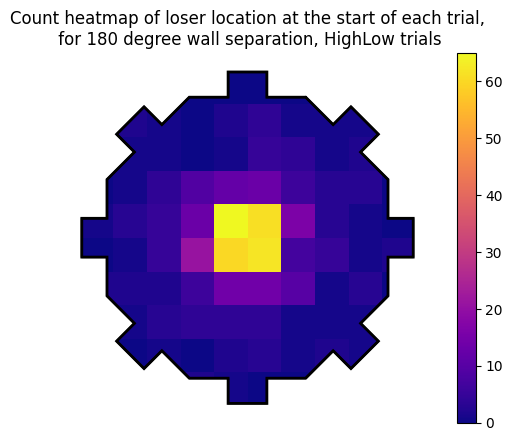

In [45]:
ax = loser_start_loc_heatmap(trial_list, wall_sep=4,
                             trial_type=globals.HIGH_LOW)
ax.set_title("Count heatmap of loser location at the start of each trial,\n for 180 degree wall separation, HighLow trials")
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.gca().tick_params(left=False, bottom=False)  # Turn off major ticks
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.show()

In [46]:
ax = probability_chose_wall_location_heatmap(trial_list, wall_sep=1,
                                                        trial_type=globals.HIGH_LOW,
                                                        chosen_wall=globals.WALL_1,
                                                        include_inferred_choice=True,
                                                        bincounts=False)
ax.set_title("Probability of choose High across locations at the start of each trial,\n for 45 degree wall separation")

d:\tom\documents\swc\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
d:\tom\documents\swc\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
d:\tom\documents\swc\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


trial_indices_inferred_choice_confident: 577
trial_indices_inferred_choice_confident_and_relevant: 305
len trial_list_filtered_inferred_choice_confident = 577
len trial_list_filtered_chose_wall_inferred_choice_confident = 305


AttributeError: 'list' object has no attribute 'iloc'

d:\tom\documents\swc\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:319: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
d:\tom\documents\swc\repos\octagon_analysis\analysis\loser_inferred_choice.py:45: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
d:\tom\documents\swc\repos\octagon_analysis\analysis\loser_inferred_choice.py:146: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


trial_indices_inferred_choice_confident: 378
trial_indices_inferred_choice_confident_and_relevant: 108
len trial_list_filtered_inferred_choice_confident = 378
len trial_list_filtered_chose_wall_inferred_choice_confident = 108
len flip_rotated_trials_inferred_choice_confident = 378
len flip_rotated_trials_chose_wall_inferred_choice_confident = 108
 shape[1] of loser_slice_onset_loc = 378
 shape[1] of loser_slice_onset_loc_chose_wall = 108
 loser_slice_onset_loc: [[-7.47357607 -3.5747797  -2.28244686 -0.10315787 -7.04695375  8.1440164
  -4.93045062  4.17218351  3.69731975 -1.77336837]
 [ 0.01618282 -9.26623348 -1.35215425 -2.32706061 -3.61645653 -7.3733311
  -8.84029777 -3.87177825  1.88329566 -1.21641779]]
 loser_slice_onset_loc: [[ -1.05554867   1.48824538  -1.35583812   2.86997806  -4.71317603
  -10.6165214   -8.54767338  -5.07495513  -0.24214831  -3.79121633]
 [  0.37604171   1.7629841   -1.33463377  -3.5911763    0.97970467
   -2.86759335  -9.99269966  -8.93261133 -15.50401402   1.3

Text(0.5, 1.0, 'Probability heatmap of choose Low across locations at the start of each trial,\n for 45 degree wall separation, HighLow trials')

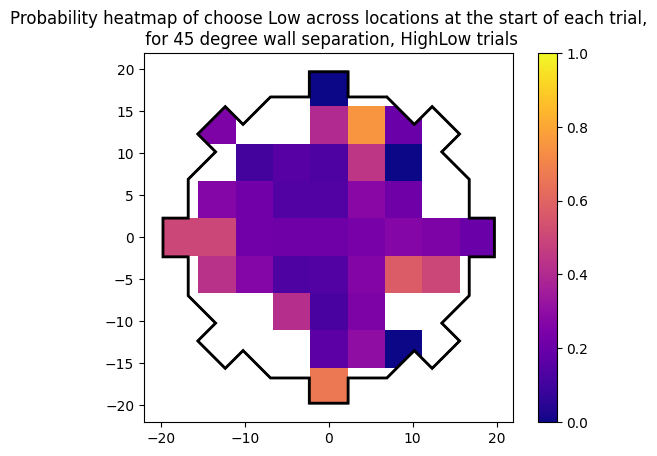

In [34]:
ax = probability_chose_wall_location_heatmap(trial_list, wall_sep=1,
                                            trial_type=globals.HIGH_LOW,
                                            chosen_wall=globals.WALL_2)
ax.set_title("Probability heatmap of choose Low across locations at the start of each trial,\n for 45 degree wall separation, HighLow trials")

### Difference between winner's and loser's normalised start loc heatmaps

In [308]:
wall_sep = None
no_flip_rotate =False
nbins = 7
# vmax=0.016
# vmin=-0.017
vmax=None
vmin=None

 flip_rotate_trials len: 1949
player_0_slice_onset_loc shape = (1949, 2)
total counts by location:
 [[  0.   0.   0.   3.  18.   8.   2.   0.   0.   0.]
 [  0.   5.   8.   8.  13.  19.  13.  12.  10.   0.]
 [  0.  12.  17.  23.  31.  47.  24.  13.  18.   0.]
 [  8.  11.  23.  76. 111. 129.  41.  18.  11.   4.]
 [  9.  13.  35. 125. 422. 436. 112.  35.  11.   8.]
 [ 13.  14.  35. 127. 419. 428. 129.  29.   7.  12.]
 [  3.  14.  24.  64. 110. 123.  67.  19.  18.   2.]
 [  0.   7.  13.  24.  31.  53.  22.  15.  11.   0.]
 [  0.   8.  14.   7.  14.  16.  11.  11.  10.   0.]
 [  0.   0.   0.   5.  11.  16.   0.   0.   0.   0.]]


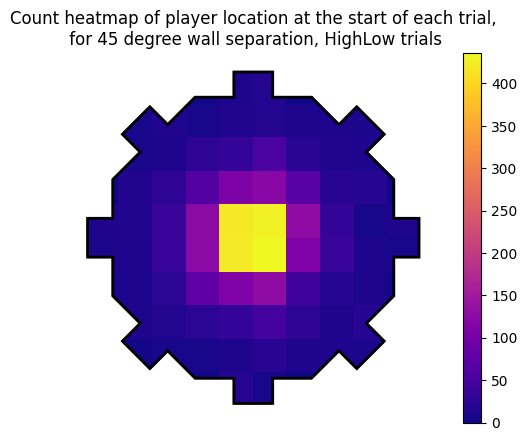

In [309]:
ax = start_loc_heatmap(trial_list, wall_sep=wall_sep,
                             trial_type=globals.HIGH_LOW,
                             chosen_wall=None)
ax.set_title("Count heatmap of player location at the start of each trial,\n for 45 degree wall separation, HighLow trials")
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.gca().tick_params(left=False, bottom=False)  # Turn off major ticks
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.show()

number of trials with trial_type HighLow is: 1949
number of trials in count_array is: 1949.0
total counts by location:
 [[  0.   0.   1.  11.   1.   0.   0.]
 [  0.   7.   6.  23.  13.  15.   1.]
 [  4.  12.  55. 143.  54.  18.   1.]
 [ 17.  23. 157. 603. 170.  22.  19.]
 [  3.  19.  66. 182. 106.  22.   7.]
 [  1.  24.  18.  34.  26.  28.   0.]
 [  0.   0.   6.  23.   5.   3.   0.]]


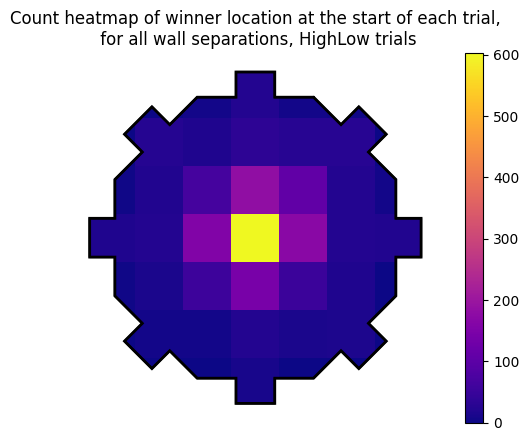

In [310]:
ax, count_array_winner = winner_start_loc_heatmap(trial_list, wall_sep=wall_sep,
                             trial_type=globals.HIGH_LOW,
                             chosen_wall=None,
                             bin_counts=True,
                             nbins=nbins,
                             no_flip_rotate=no_flip_rotate)
ax.set_title("Count heatmap of winner location at the start of each trial,\n for all wall separations, HighLow trials")
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.gca().tick_params(left=False, bottom=False)  # Turn off major ticks
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.show()

total counts by location:
 [[  0.   2.   5.  17.   2.   2.   0.]
 [  1.  13.  21.  37.  24.  15.   0.]
 [  6.  15.  79. 163.  59.  24.   3.]
 [  9.  26. 163. 570. 160.  27.  11.]
 [  6.  25.  74. 153.  77.  24.   5.]
 [  0.  17.  14.  30.  18.  19.   0.]
 [  0.   0.   9.  21.   2.   1.   0.]]


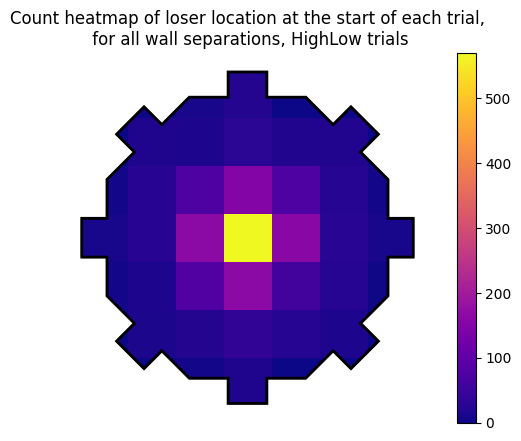

In [311]:
ax, count_array_loser = loser_start_loc_heatmap(trial_list, wall_sep=wall_sep,
                             trial_type=globals.HIGH_LOW,
                             chosen_wall=None,
                             bin_counts=True,
                             nbins=nbins,
                             no_flip_rotate=no_flip_rotate)
ax.set_title("Count heatmap of loser location at the start of each trial,\n for all wall separations, HighLow trials")
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.gca().tick_params(left=False, bottom=False)  # Turn off major ticks
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.show()

In [312]:
np.nansum(count_array_winner)

np.float64(1949.0)

In [313]:
winner_norm = count_array_winner/np.nansum(count_array_winner)
loser_norm = count_array_loser/np.nansum(count_array_loser)

total counts by location:
 [[0.         0.         0.00051308 0.00564392 0.00051308 0.
  0.        ]
 [0.         0.00359159 0.0030785  0.01180092 0.00667009 0.00769625
  0.00051308]
 [0.00205233 0.006157   0.0282196  0.07337096 0.02770652 0.00923551
  0.00051308]
 [0.00872242 0.01180092 0.08055413 0.30938943 0.08722422 0.01128784
  0.00974859]
 [0.00153925 0.00974859 0.03386352 0.09338122 0.05438687 0.01128784
  0.00359159]
 [0.00051308 0.01231401 0.00923551 0.01744484 0.01334017 0.01436634
  0.        ]
 [0.         0.         0.0030785  0.01180092 0.00256542 0.00153925
  0.        ]]


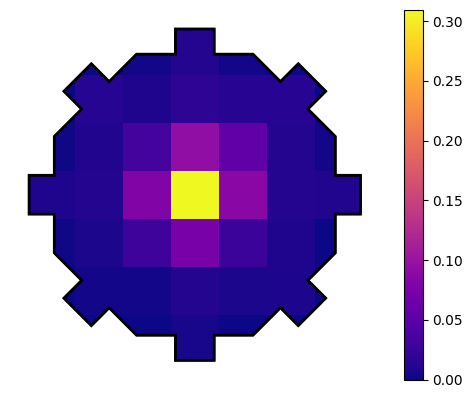

In [314]:
ax = plot_octagon.plot_octagon()
ax = plot_heatmap_from_count_array(ax, winner_norm)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.gca().tick_params(left=False, bottom=False)  # Turn off major ticks
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.show()

In [315]:
winner_loser_diff = winner_norm - loser_norm


total counts by location:
 [[ 0.         -0.00102617 -0.00205233 -0.0030785  -0.00051308 -0.00102617
   0.        ]
 [-0.00051308 -0.0030785  -0.00769625 -0.00718317 -0.00564392  0.
   0.00051308]
 [-0.00102617 -0.00153925 -0.01231401 -0.01026167 -0.00256542 -0.0030785
  -0.00102617]
 [ 0.00410467 -0.00153925 -0.0030785   0.01693176  0.00513084 -0.00256542
   0.00410467]
 [-0.00153925 -0.0030785  -0.00410467  0.01487943  0.01487943 -0.00102617
   0.00102617]
 [ 0.00051308  0.00359159  0.00205233  0.00205233  0.00410467  0.00461775
   0.        ]
 [ 0.          0.         -0.00153925  0.00102617  0.00153925  0.00102617
   0.        ]]


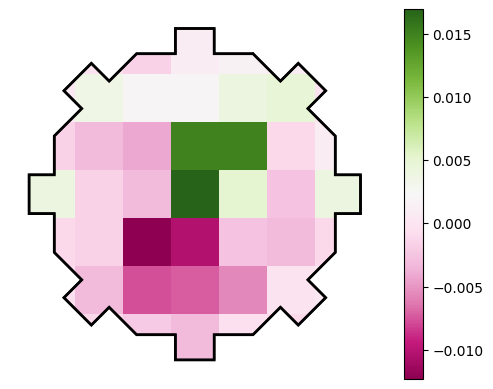

In [316]:
ax = plot_octagon.plot_octagon()
ax = plot_heatmap_from_count_array(ax, winner_loser_diff,
                                   difference_plot=True,
                                   vmin=vmin, vmax=vmax)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.gca().tick_params(left=False, bottom=False)  # Turn off major ticks
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.show()